In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [126]:
# Example of coupled execution
# log_files = {'new': 'slurm-4240.out'}

# Example of completed uncoupled, with bad node?
log_files = {'new': 'slurm-4457.out'}

# Example of completed uncoupled, without bad node?
log_files = {'new': 'slurm-4459.out'}

# log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [141]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            #
            # Sample new line in log file:
            #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
            #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
            #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
            #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
            index = 1
            pe = int(tokens[index])
            index += 3
            
            timestep = int(tokens[index])
            index += 3
            
            total = float(tokens[index])
            index += 4
            
            metadata = float(tokens[index])
            index += 6
            
            summary = float(tokens[index])
            index += 2
            summary_actor_partitions = float(tokens[index][1:])
            index += 1
            summary_time_window = float(tokens[index])
            index += 1
            summary_update_neighbors = float(tokens[index])
            index += 2
            summary_update_neighbors_lock = float(tokens[index])
            index += 1
            summary_update_neighbors_getmem = float(tokens[index])
            index += 1
            summary_update_neighbors_unlock = float(tokens[index])
            index += 1
            summary_update_neighbors_body = float(tokens[index][:len(tokens[index]) - 1])
            index += 3
            
            edges = float(tokens[index])
            index += 2
            edges_updates = float(tokens[index][1:])
            index += 1
            edges_getmem = float(tokens[index][:-1])
            index += 4
            
            neighbor_updates = float(tokens[index])
            index  += 5
            
            coupled_values = float(tokens[index])
            index += 4
            
            coupling = float(tokens[index])
            index += 2
            
            n_coupled_spins_str = tokens[index]
            n_coupled_spins_str = n_coupled_spins_str[1:]
            n_coupled_spins_str = n_coupled_spins_str[:len(n_coupled_spins_str) - 1]
            n_coupled_spins = int(n_coupled_spins_str)
            index += 3
            
            throttling = float(tokens[index])
            index += 3
            
            spins = int(tokens[index])
            index += 3
            
            n_neighbors = int(tokens[index])
            index += 10
            
            active_partitions = int(tokens[index])
            index += 14
            
            cache_hits_str = tokens[index]
            cache_hits = int(cache_hits_str.split('=')[1])
            index += 1
            
            cache_misses_str = tokens[index]
            cache_misses = int(cache_misses_str.split('=')[1])
            index += 2
            
            cache_age_misses_str = tokens[index]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'timestep': timestep,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'summary_actor_partitions': summary_actor_partitions,
                                 'summary_time_window': summary_time_window,
                                 'summary_update_neighbors': summary_update_neighbors,
                                 'summary_update_neighbors_lock': summary_update_neighbors_lock,
                                 'summary_update_neighbors_getmem': summary_update_neighbors_getmem,
                                 'summary_update_neighbors_unlock': summary_update_neighbors_unlock,
                                 'summary_update_neighbors_body': summary_update_neighbors_body,
                                 'edges': edges,
                                 'edges_updates': edges_updates,
                                 'edges_getmem': edges_getmem,
                                 'neighbor_updates': neighbor_updates,
                                 'coupling': coupling,
                                 'n_coupled_spins': n_coupled_spins,
                                 'coupled_values': coupled_values,
                                 'throttling': throttling,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [142]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

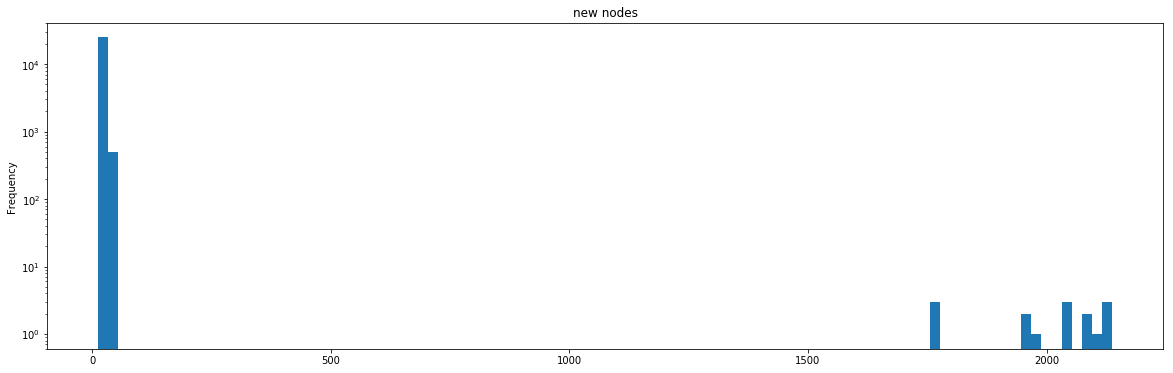

In [143]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

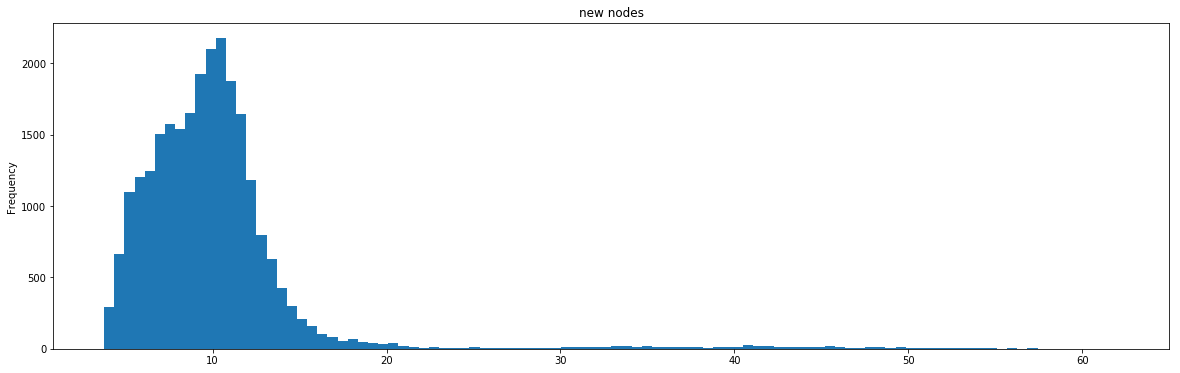

In [75]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

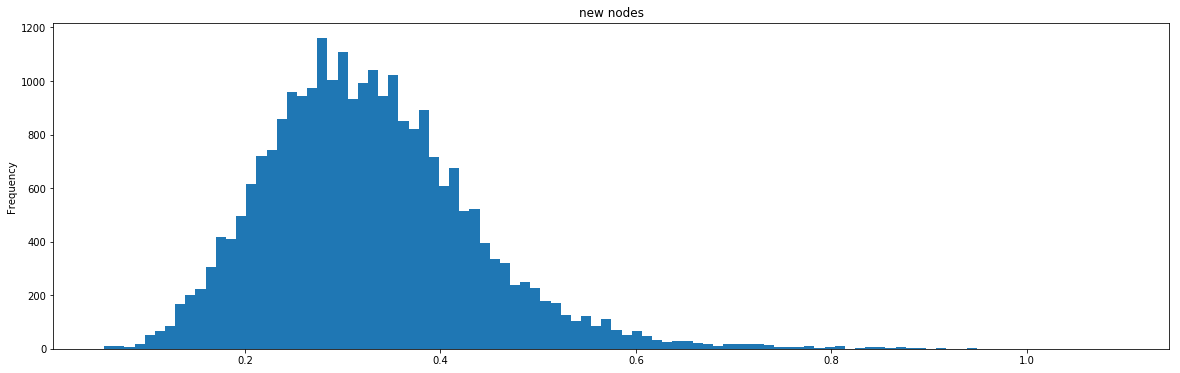

In [76]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [77]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges', u'metadata',
       u'n_coupled_spins', u'n_neighbors', u'neighbor_updates', u'pe',
       u'spins', u'summary', u'summary_actor_partitions',
       u'summary_time_window', u'summary_update_neighbors',
       u'summary_update_neighbors_body', u'summary_update_neighbors_getmem',
       u'summary_update_neighbors_lock', u'summary_update_neighbors_unlock',
       u'throttling', u'timestep', u'total'],
      dtype='object')

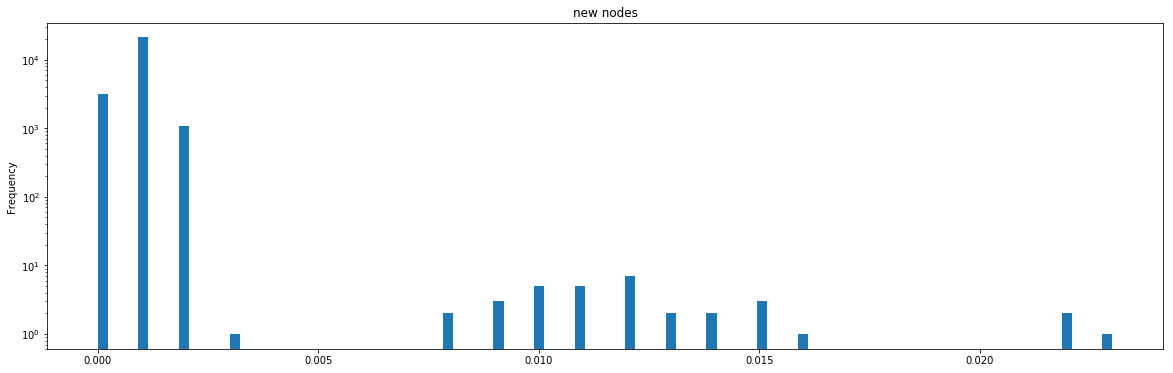

In [78]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

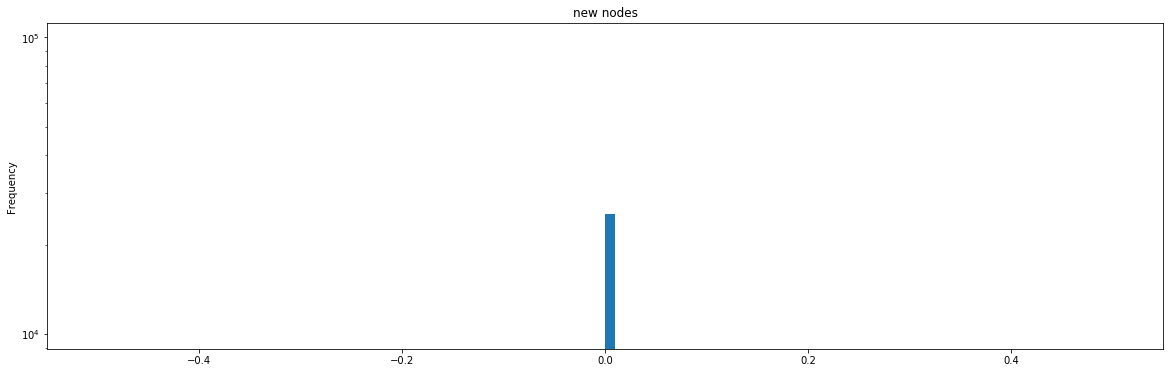

In [79]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['n_coupled_spins'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [80]:
dfs['new'].sort_values(by = 'coupling', ascending = False)

,active_partitions,cache_age_misses,cache_hits,cache_misses,coupled_values,coupling,edges,metadata,n_coupled_spins,n_neighbors,...,summary_actor_partitions,summary_time_window,summary_update_neighbors,summary_update_neighbors_body,summary_update_neighbors_getmem,summary_update_neighbors_lock,summary_update_neighbors_unlock,throttling,timestep,total
12985,47,5513,16845,370,0.018,0.023,12.354,0.487,0,6,...,0.034,0.021,9.992,0.554,2.722,3.473,3.227,0.235,59,23.241
7838,49,1343,9087,417,0.045,0.022,24.950,0.720,0,9,...,0.053,0.056,7.641,0.800,2.096,2.493,2.234,0.063,25,33.655
8280,49,2013,11893,407,0.023,0.022,13.870,0.474,0,9,...,0.041,0.026,8.267,0.590,2.277,2.863,2.520,0.094,34,22.888
10098,45,2439,13887,397,0.020,0.016,15.222,0.372,0,9,...,0.039,0.028,10.069,0.783,2.958,3.270,3.045,0.089,41,25.938
7980,49,1984,11882,412,0.019,0.015,9.596,0.279,0,9,...,0.034,0.042,8.577,0.556,2.679,2.891,2.434,0.031,34,18.666
14854,45,7298,17612,354,0.017,0.015,13.542,0.308,0,6,...,0.029,0.019,9.226,0.541,2.651,3.031,2.990,0.053,69,23.282
17520,47,4954,27510,429,0.016,0.015,11.412,0.428,0,9,...,0.034,0.018,16.068,0.585,4.757,5.247,5.468,0.036,76,28.095
15011,46,4125,23657,413,0.015,0.014,10.645,0.473,0,9,...,0.035,0.022,11.793,0.523,3.395,4.292,3.566,0.064,66,23.127
24050,47,11384,31409,423,0.015,0.014,21.422,0.304,0,9,...,0.021,0.016,6.546,0.520,1.909,2.073,2.032,0.023,99,28.423
11825,46,4885,14634,364,0.016,0.013,12.249,0.245,0,6,...,0.025,0.017,11.550,0.520,3.194,3.929,3.894,0.044,53,24.222


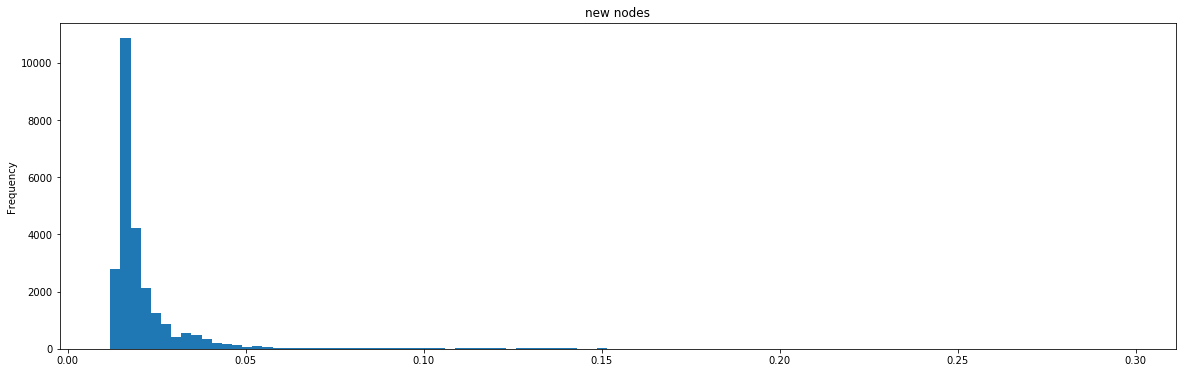

In [81]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupled_values'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

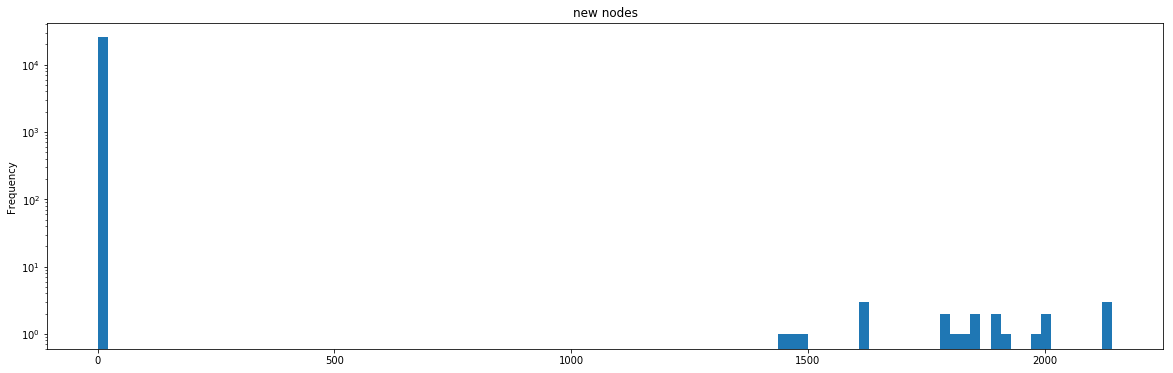

In [82]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

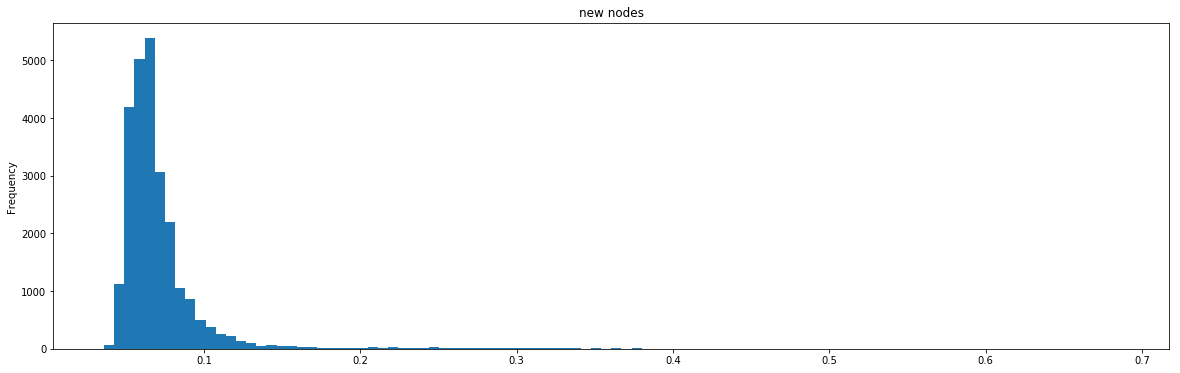

In [83]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

In [84]:
dfs['new']['coupling'].min()

0.0

In [144]:
# On run 4240, the infection starts on PE 188.
# It never reaches PE 223.
# The real performance problem here is that as soon as a PE couples with 188 (or some other PE that has been infected),
# that other PE has generally been making much slower progress. Hence, the newly coupled PE has to wait a long time for
# it to catch up. Below, I look at the different progressions over time and distributions of time for different kernels
# to see what this difference in performance is generally caused by.

df = dfs['new']
pe_188 = df[df['pe'].isin([188])].sort_values(by = 'timestep')
pe_187 = df[df['pe'].isin([187])].sort_values(by = 'timestep')
pe_223 = df[df['pe'].isin([223])].sort_values(by = 'timestep')
pe_99 = df[df['pe'].isin([99])].sort_values(by = 'timestep')
pe_100 = df[df['pe'].isin([100])].sort_values(by = 'timestep')
pe_0 = df[df['pe'].isin([0])].sort_values(by = 'timestep')

In [145]:
pe_188.columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

In [146]:
len(pe_188), len(pe_187)

(99, 99)

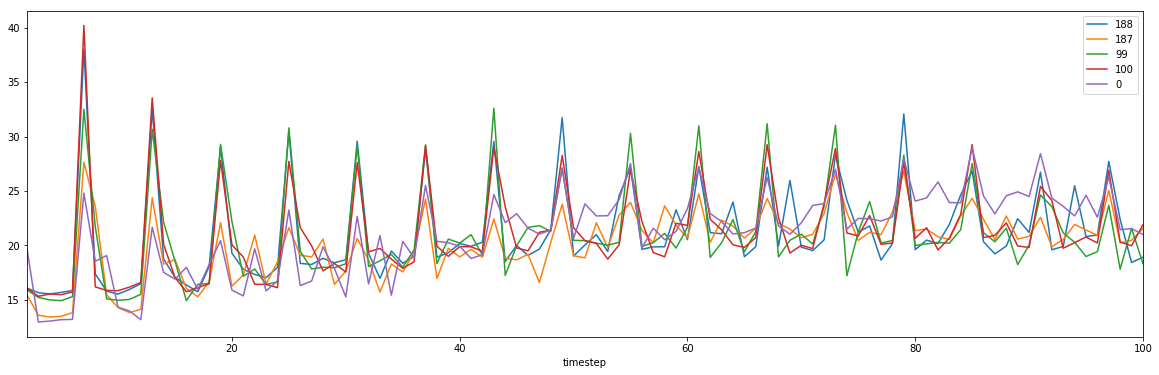

In [147]:
def plot_for_metric(metric):
    # to_plot = ['188', '223', '99']
    to_plot = ['188', '187', '99', '100', '0']
    len_shortest_df = len(pe_187)
    
    pd.DataFrame({'timestep': pe_188['timestep'].values[:len_shortest_df],
           '188': pe_188[metric].values[:len_shortest_df],
           '187': pe_187[metric].values[:len_shortest_df],
           '223': pe_223[metric].values[:len_shortest_df],
           '99': pe_99[metric].values[:len_shortest_df],
           '100': pe_100[metric].values[:len_shortest_df],
           '0': pe_0[metric].values[:len_shortest_df]}).plot(kind = 'line',
                                                                 x = 'timestep', y = to_plot, figsize = (20.0, 6.0))

plot_for_metric('total')

Series([], Name: pe, dtype: int64)

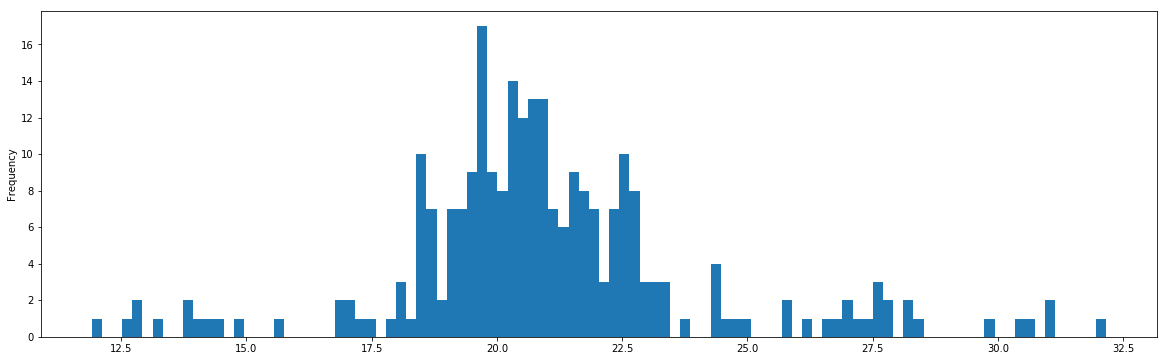

In [148]:
total_at_45 = df[df['timestep'].isin([45])]
total_at_45['total'].plot(kind = 'hist', figsize = (20, 6), bins = 100)
total_at_45[total_at_45['total'] > 50.0].sort_values(by = 'pe')['pe']

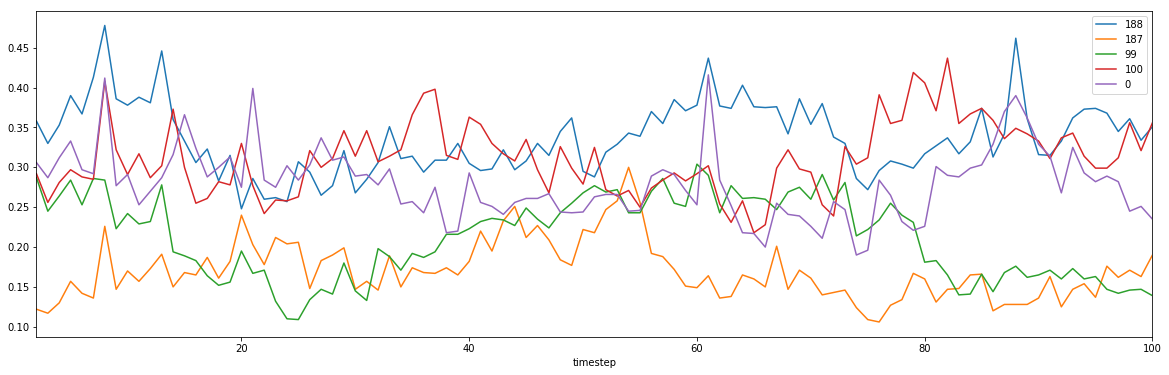

In [149]:
plot_for_metric('metadata')

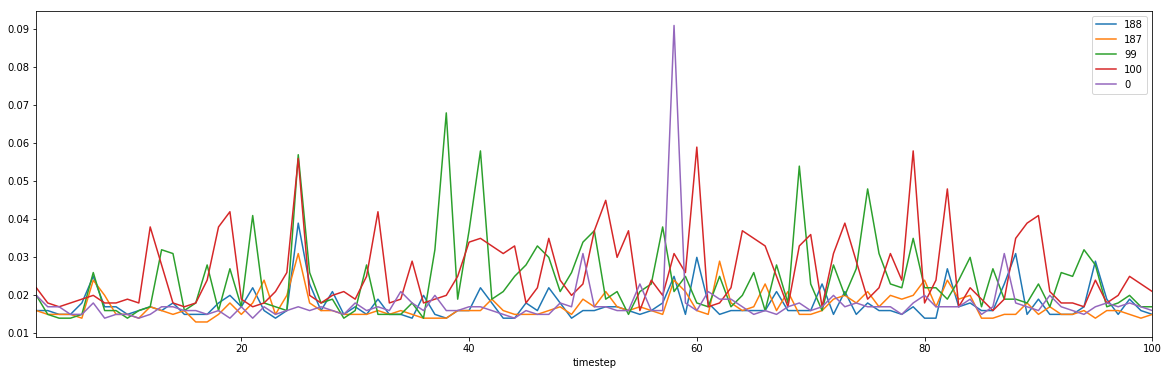

In [150]:
# 'coupled_values', 'coupling', 'edges', 'neighbor_updates', 'summary', 'throttling'
plot_for_metric('coupled_values')

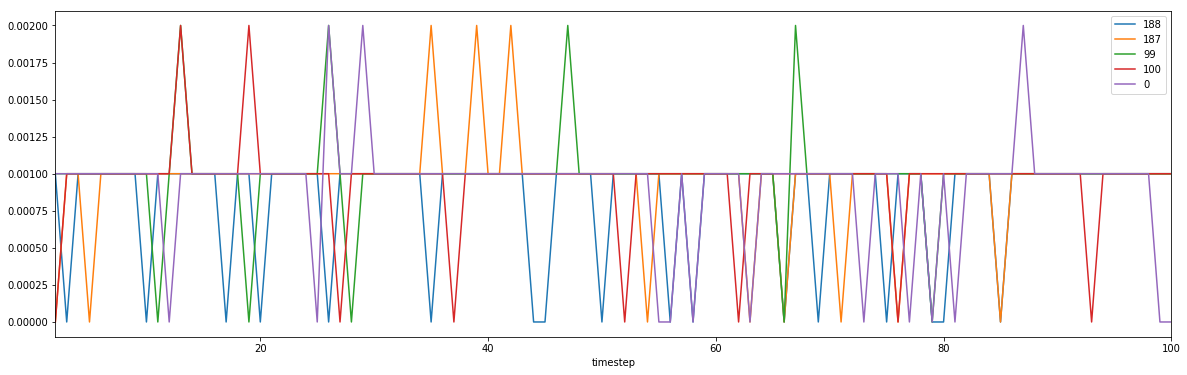

In [151]:
plot_for_metric('coupling')

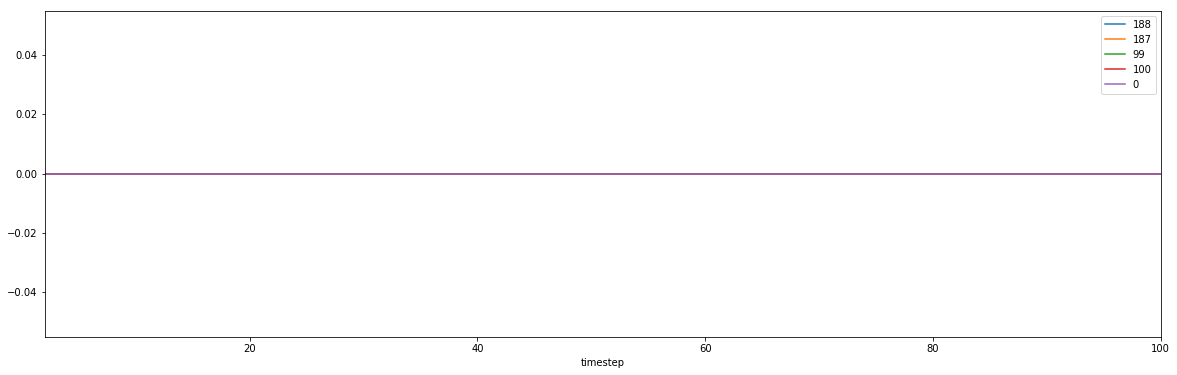

In [152]:
plot_for_metric('n_coupled_spins')

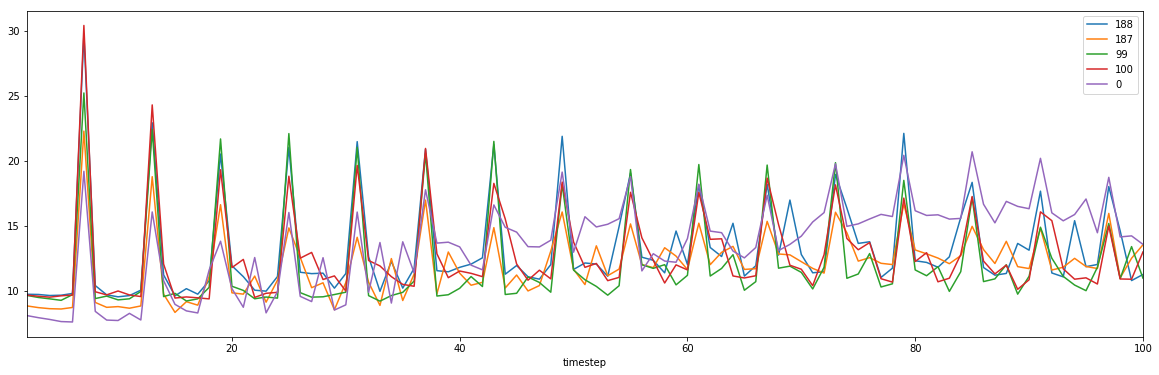

In [153]:
plot_for_metric('edges')

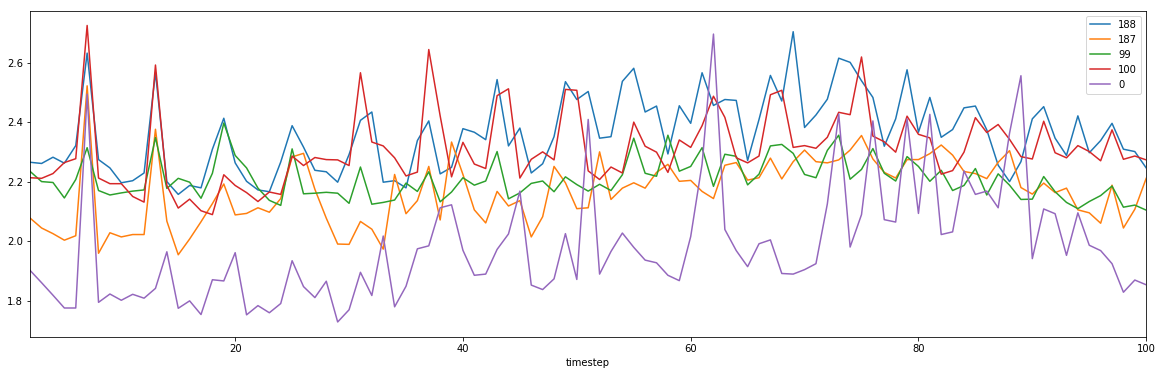

In [154]:
plot_for_metric('edges_updates')

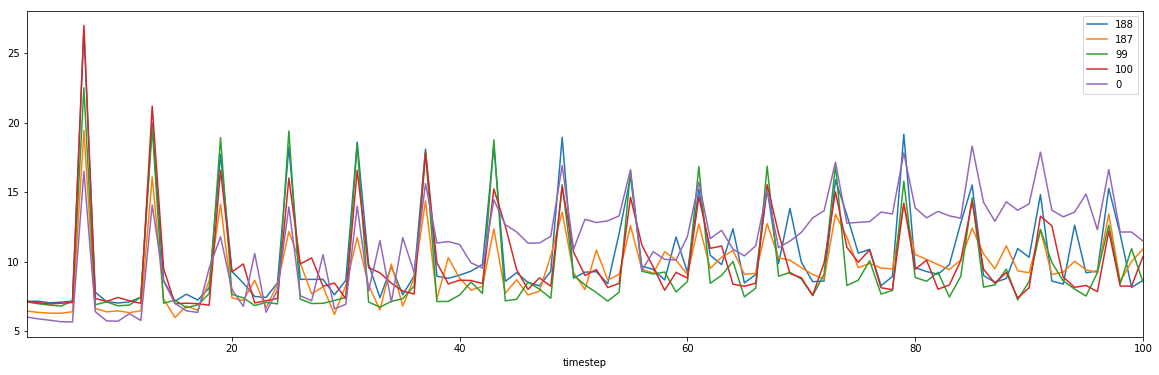

In [155]:
plot_for_metric('edges_getmem')

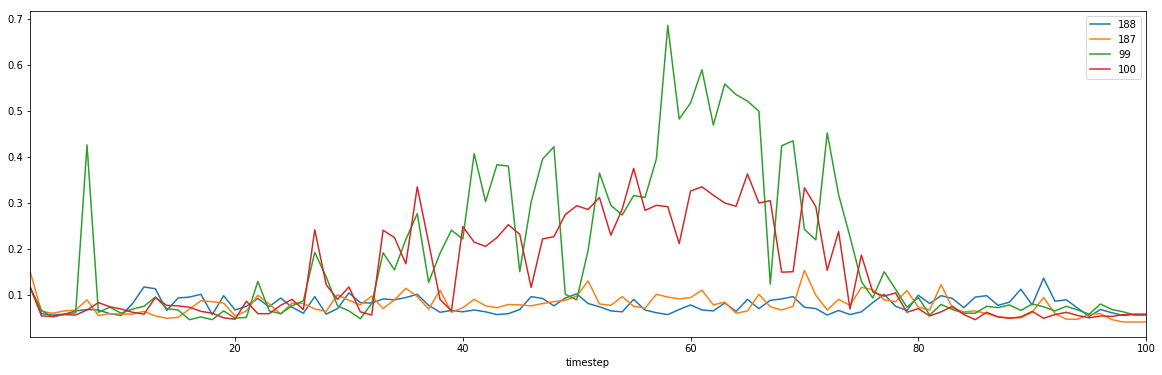

In [94]:
plot_for_metric('neighbor_updates')

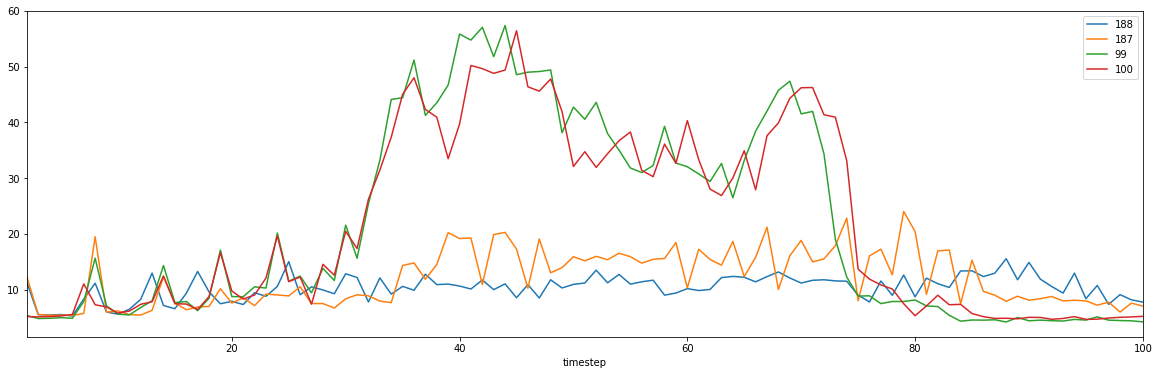

In [95]:
plot_for_metric('summary')

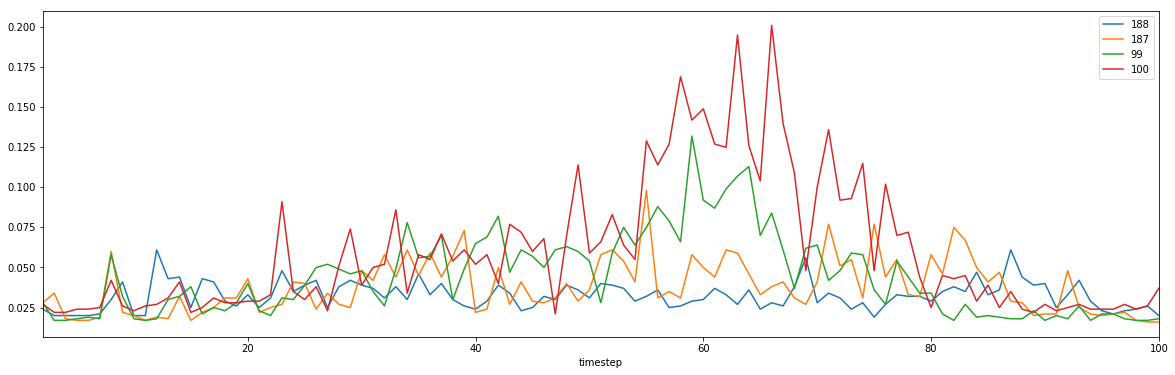

In [96]:
plot_for_metric('summary_actor_partitions')

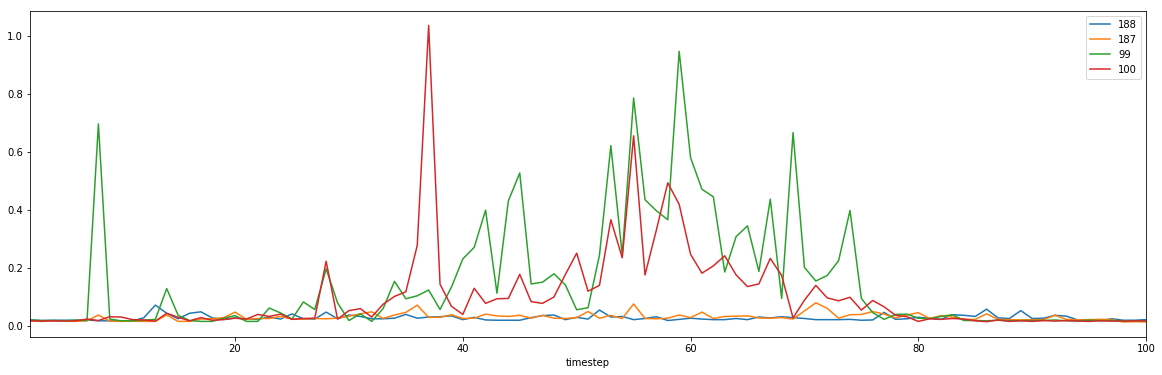

In [97]:
plot_for_metric('summary_time_window')

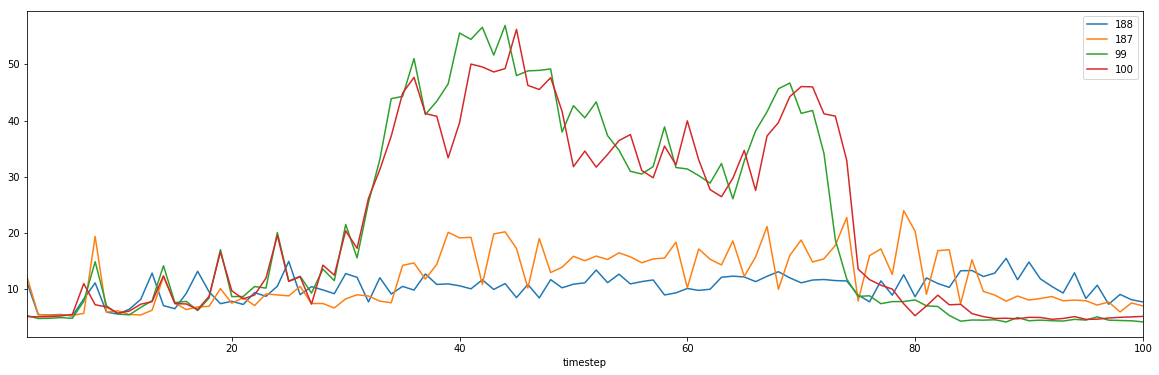

In [98]:
plot_for_metric('summary_update_neighbors')

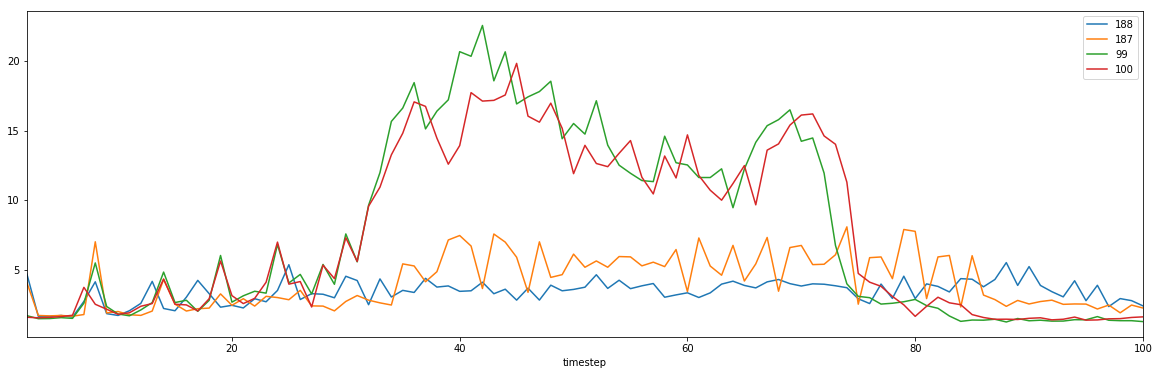

In [99]:
plot_for_metric('summary_update_neighbors_lock')

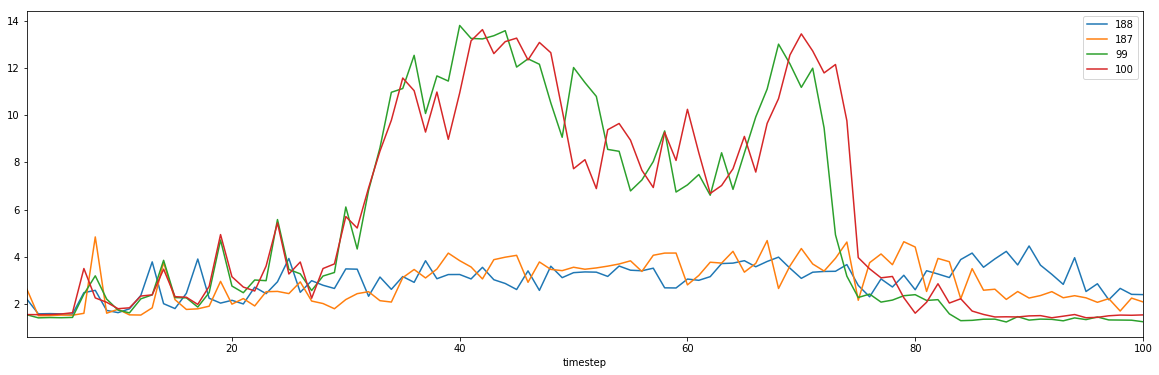

In [100]:
plot_for_metric('summary_update_neighbors_getmem')

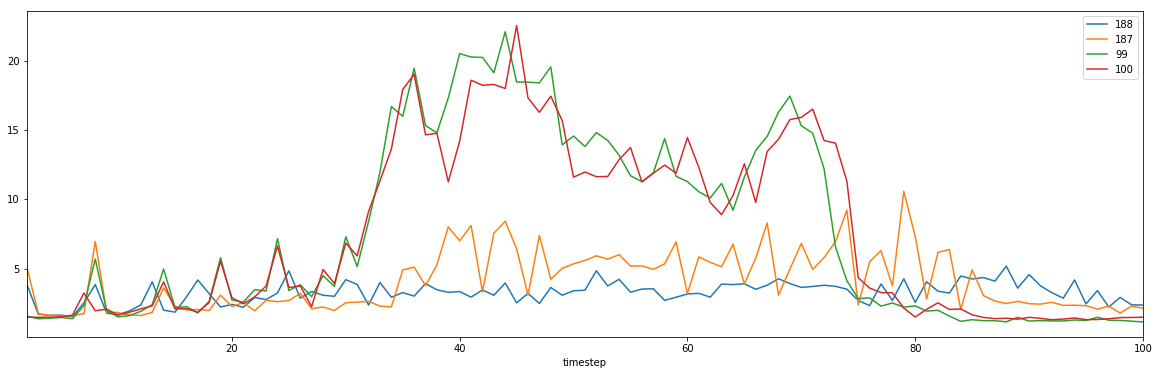

In [101]:
plot_for_metric('summary_update_neighbors_unlock')

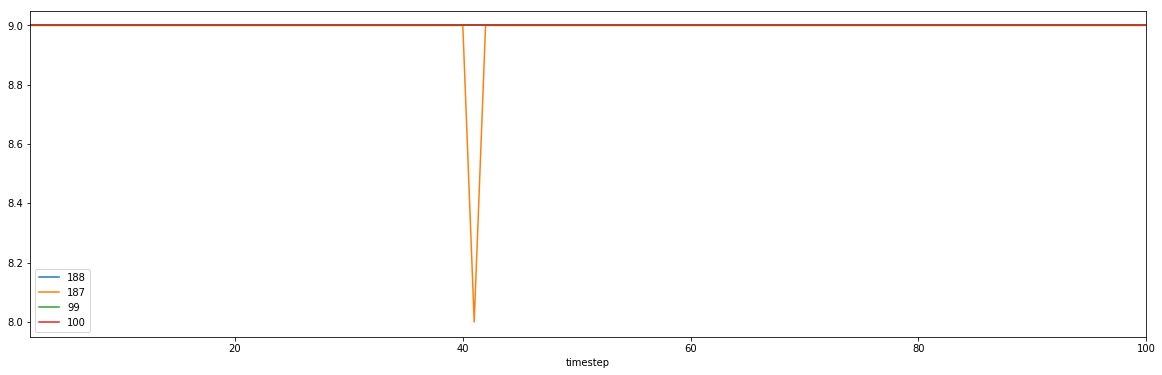

In [105]:
plot_for_metric('n_neighbors')

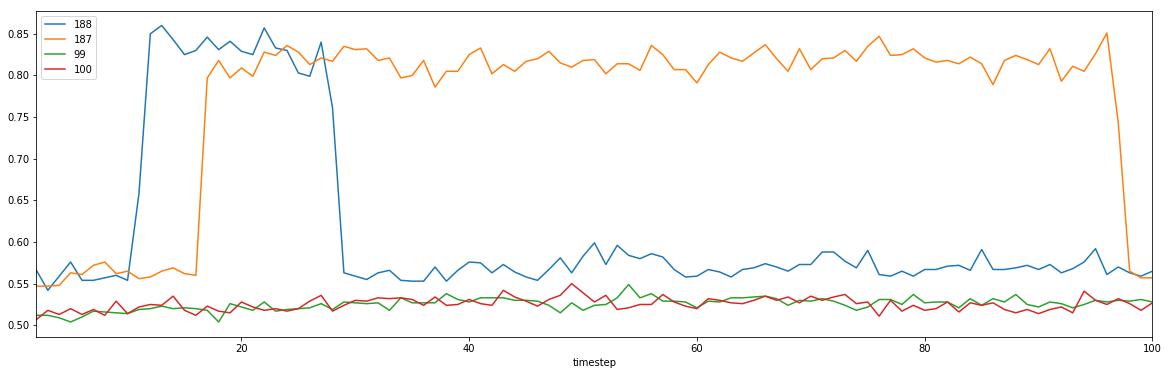

In [102]:
plot_for_metric('summary_update_neighbors_body')

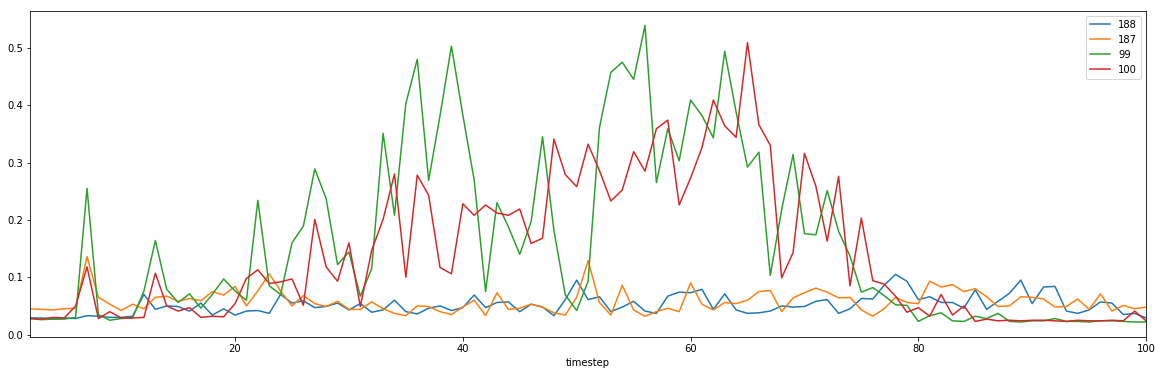

In [103]:
plot_for_metric('throttling')